# Grids and Cube Files in Psi4

In this tutorial, we extend the use of the grid from tutorial 4a. Although grids that come from the basis set's Gaussians are good for computations, they are not good for visualizing scalar fields in space. Every element from the SCF calculation that is expressed in a basis set can also be expressed on the grid. Here it is shown how we can obtain both frameworks using elements from Psi4.

In [1]:
import psi4
import numpy as np
from scipy import ndimage
import libcubeprop

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## I. Spherical Grid

First, let us do a a Psi4 calculation in a water molecule.

In [2]:
#Options for number of angular and radial points. 
psi4.set_options({"DFT_SPHERICAL_POINTS":1454,
                  "DFT_RADIAL_POINTS":10})


#Define water molecule
h2o_geometry = psi4.geometry("""
0 1

H    1.4161006    0.0000000    0.8360770
O    0.0000000    0.0000000   -0.3124675
H   -1.4161006    0.0000000    0.8360770

symmetry c1
units bohr
""")

#Calculate energy and return wavefunction object
h2o_energy, h2o_wfn = psi4.energy("PBE/cc-pVDZ", molecule=h2o_geometry,return_wfn=True)

Let us look at all the points for the basis in space. Just like we did in tutorial 4a, we compute the objects required to explicitly produce the points in space.

In [37]:
#Basis
basis = psi4.core.BasisSet.build(h2o_geometry, "ORBITAL", "CC-PVDZ")

#Functional
sup = psi4.driver.dft.build_superfunctional("PBE", True)[0]

#V potential 
Vpot = psi4.core.VBase.build(basis, sup, "RV")
Vpot.initialize()

#Get the points and weights for each points. The weights are used for integrating on the grid.
x, y, z, w = Vpot.get_np_xyzw()

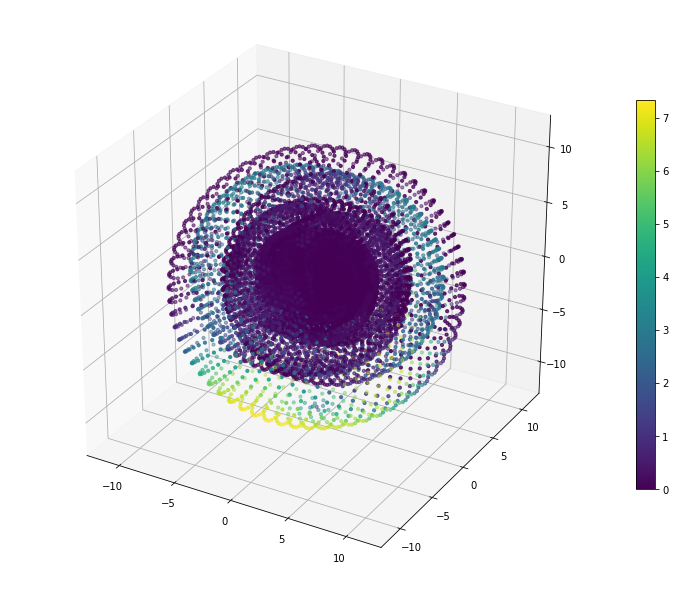

In [21]:
#Use matplotlib to visualize all of the grid. 
fig = plt.figure(figsize=(9,8))
ax = Axes3D(fig)

p = ax.scatter(x, y, z, c=w, s=10)
plt.colorbar(p, fraction=0.030, pad=0.04)


With the current settings of radial and spherical points, we have a total of 43,620 points describing the space surrounding our molecule. This is clearly too crowded. If we only look at a thin slice on the plane where the three atoms are placed, we can see more detail.

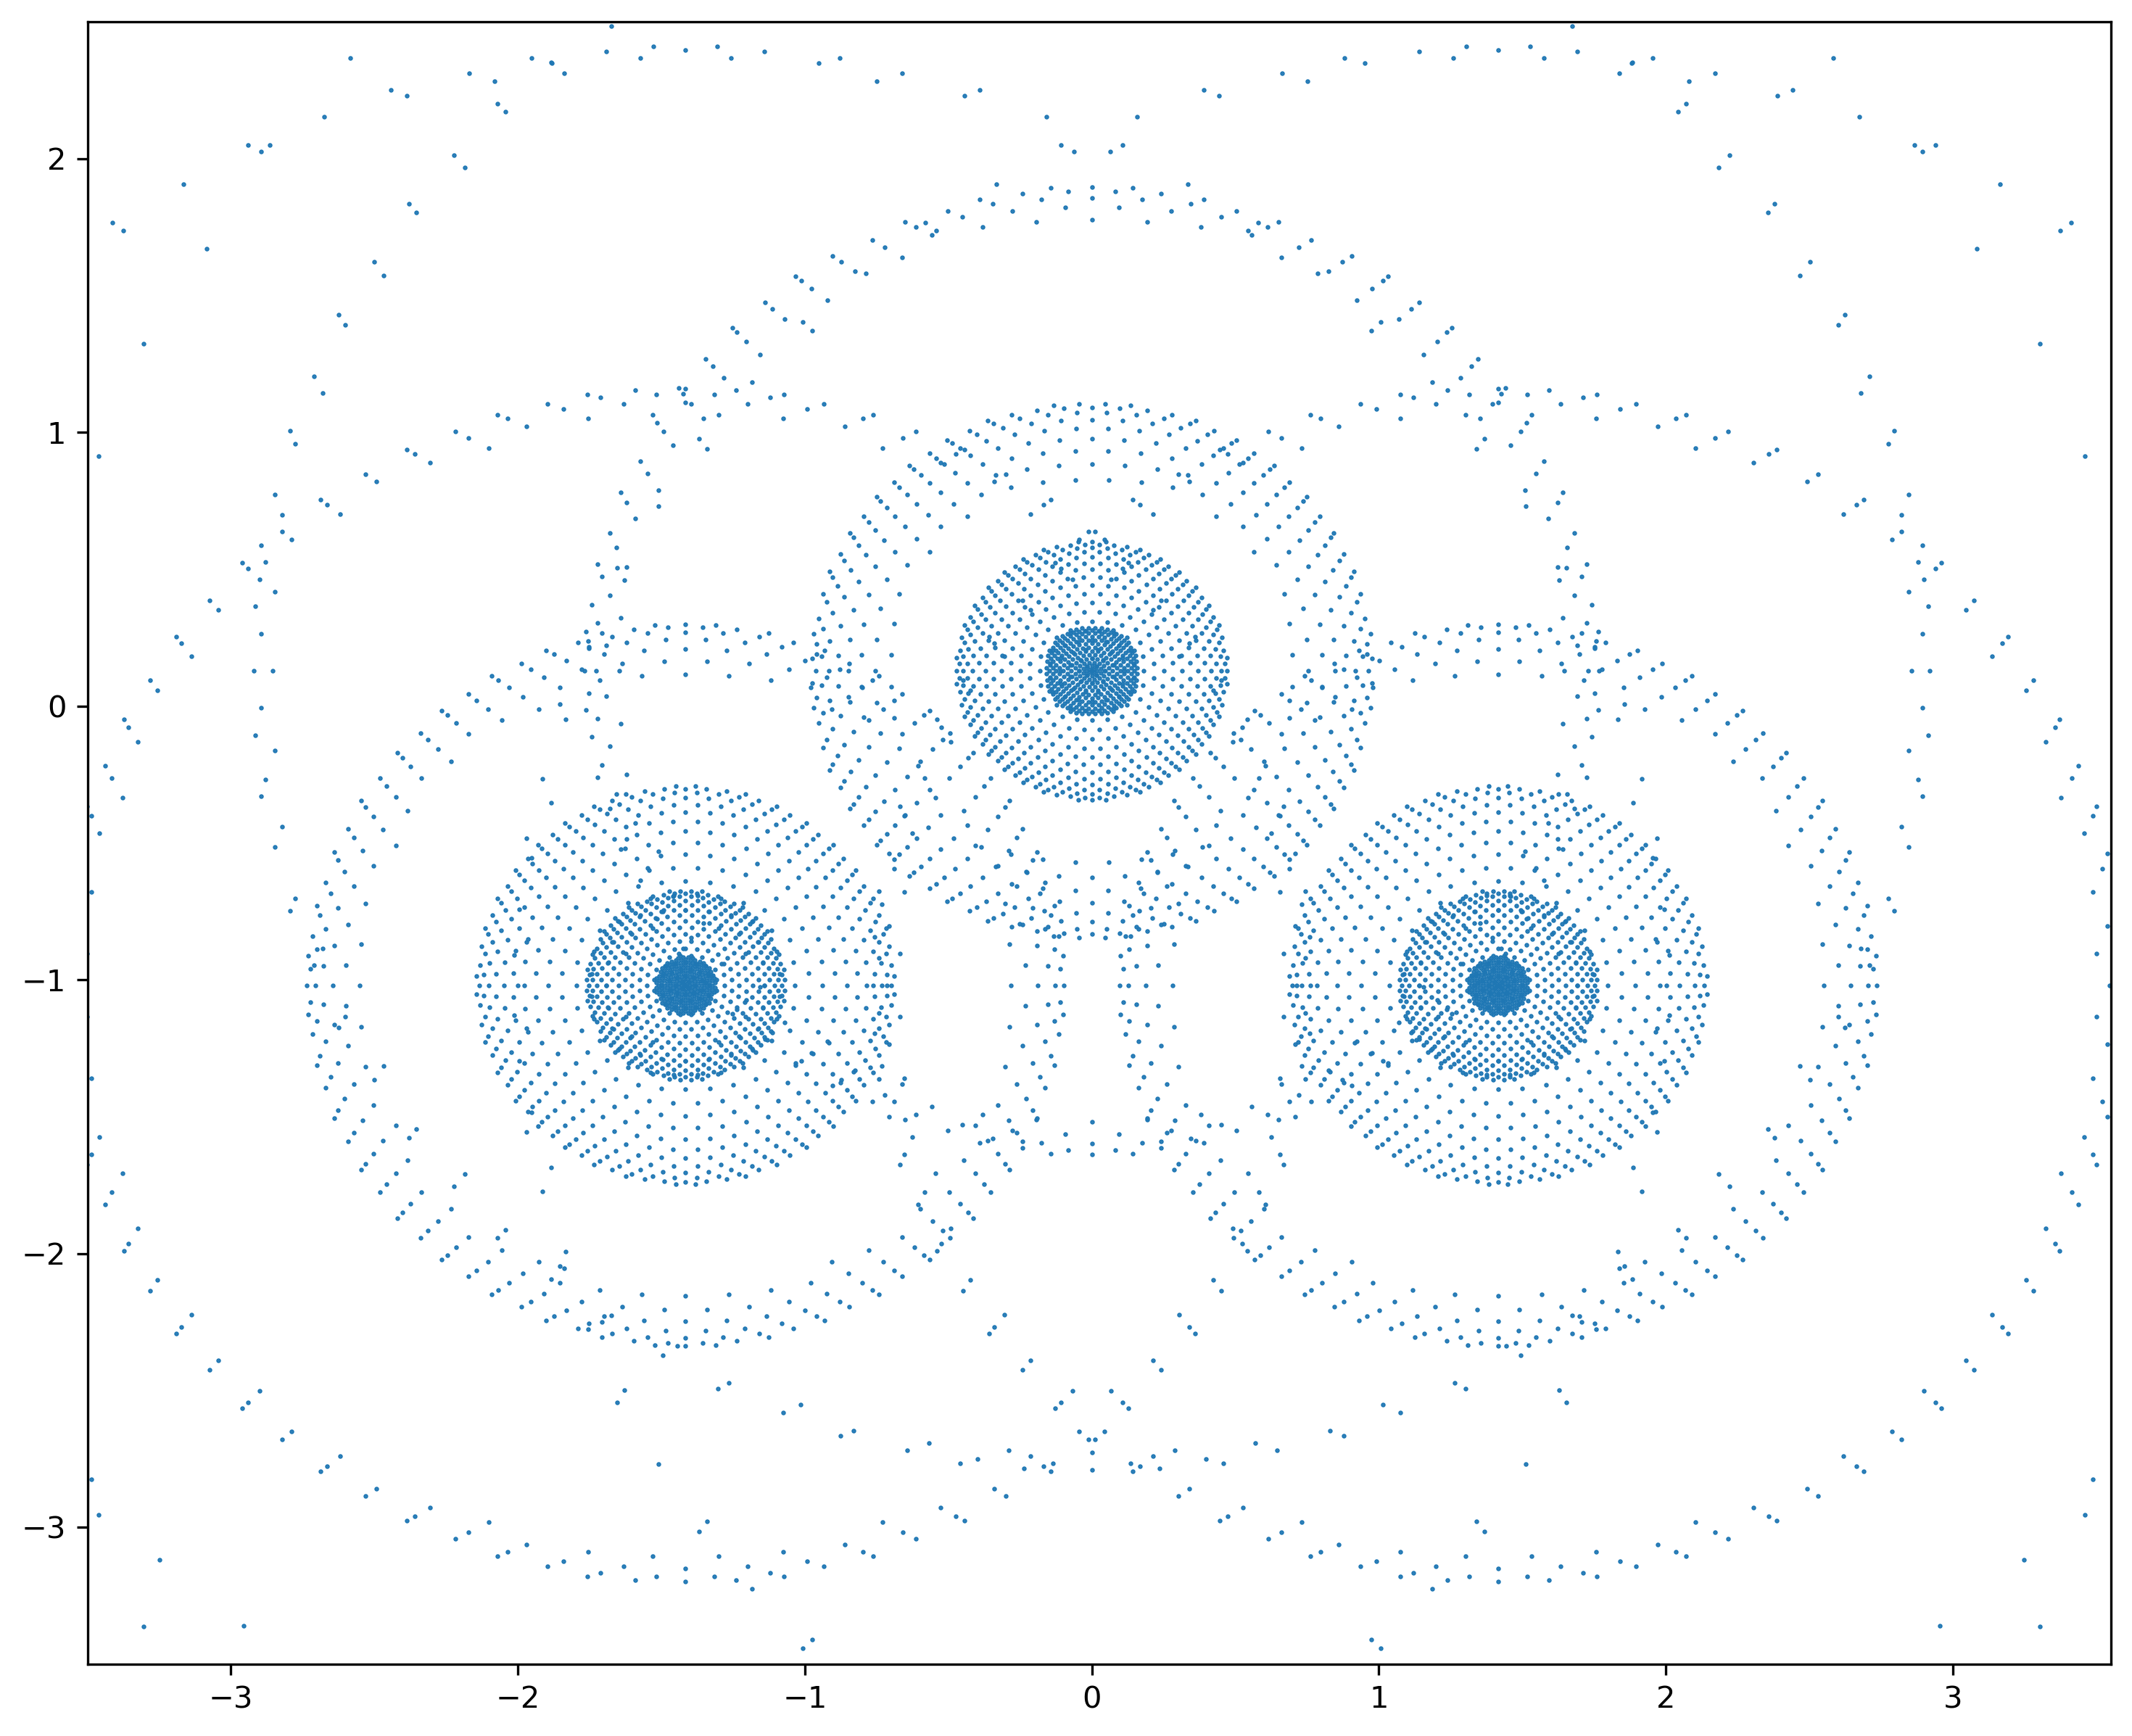

In [67]:
#Get a slice of the points surrounding the plane where the atoms are located
x_plot, z_plot = [], []
for point in range(len(x)):
        if np.isclose(y[point], 0.4, atol=3e-1):
            x_plot.append(x[point])
            z_plot.append(-1 * z[point])
            4
            
fig = plt.figure(figsize=(12,10), dpi=300)
plt.xlim(-3.5,3.55)
plt.ylim(-3.5,2.5)

plt.scatter(x_plot, z_plot, s=0.3)

We can now appreciate how the grid is centred around each atom. Moreover, the density of the points in space decreases as we move farther from each of the nuclei. 

Given that this is just a plot of the points in space, we still need to compute the value of a scalar field - such as the electronic density - for each of the points. This can be done with a modified version of the code used in the "4b LDA Kernel" tutorial, where instead of computing the exchange-correlation energy per block, we compute the value of the electron density as a contraction:


$$D_p = \sum_{\mu \nu} \phi_{\mu p} D_{\mu \nu} \phi_{\nu p} $$

In [39]:
#This function takes the wavefunction object from a Psi4 Calculation and a scalar field expressed in the AO basis set. 

def basis_to_grid(wfn, mat):
    
    nbf = wfn.basisset().nbf()
    Vpot = wfn.V_potential()

    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()

    x_block, y_block, z_block, w_block, mat_block = [], [], [], [], []

    # Loop Over Blocks
    for l_block in range(Vpot.nblocks()):

        # Obtain general grid information
        l_grid = Vpot.get_block(l_block)

        l_w = np.array(l_grid.w())
        l_x = np.array(l_grid.x())
        l_y = np.array(l_grid.y())
        l_z = np.array(l_grid.z())

        l_npoints = l_w.shape[0]
        points_func.compute_points(l_grid)

        # Recompute to l_grid
        lpos = np.array(l_grid.functions_local_to_global())

        points_func.compute_points(l_grid)
        nfunctions = lpos.shape[0]

        #Compute phi
        phi = np.array(points_func.basis_values()["PHI"])[:l_npoints, :nfunctions]
        
        #Build a local slice of a matrix in a basis set
        l_mat = mat.np[(lpos[:, None], lpos)]
        
        #Compute the its value on the grid
        mat_r = np.einsum('pm,mn,pn->p', phi, l_mat, phi, optimize=True)
        
        #Append block information into litst
        x_block.append(l_x)
        y_block.append(l_y)
        z_block.append(l_z)
        w_block.append(l_w)
        mat_block.append(mat_r[:l_npoints])


    return np.array(x_block), np.array(y_block), np.array(z_block), np.array(w_block), np.array(mat_block)

In [40]:
x_block, y_block, z_block, w_block, density_block = basis_to_grid(h2o_wfn, h2o_wfn.Da())

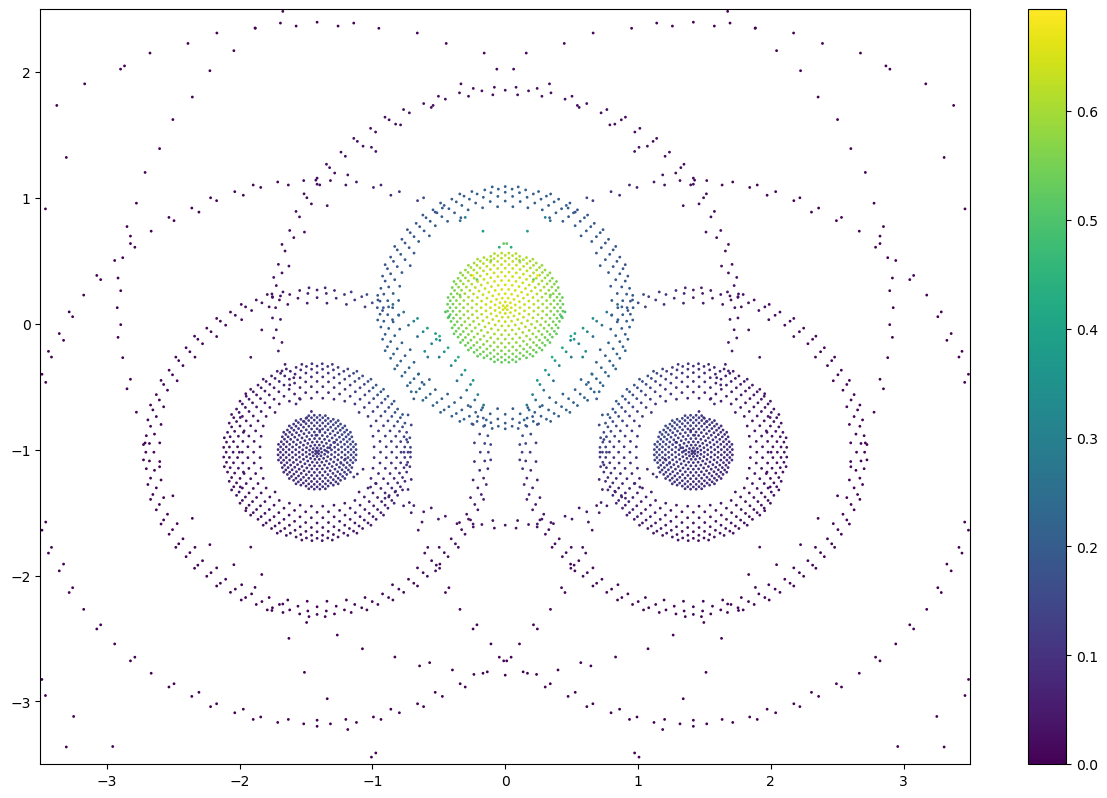

In [54]:
#Just like we did with the first grid. We just concentrate on a slice of the grid. 
x_plot, z_plot, density_plot = [], [], []
for block in range(len(density_block)):
    for point in range(len(y_block[block])):
        if np.isclose(y_block[block][point], 0.4, atol=2e-1):
            x_plot.append(x_block[block][point])
            z_plot.append(-1 * z_block[block][point])
            density_plot.append(density_block[block][point])
            
            
fig = plt.figure(figsize=(15,10), dpi=100)
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,2.5)

plt.scatter(x_plot, z_plot, c=density_plot,s=1)
plt.colorbar()


### We have now obtained the value of the electron density for each grid point. 
This grid is not appropriate for visualizing the electron density on the grid. We require a more homogeneous grid. 

## 2. Rectangular Grid

This is where cube files become relevant. These files contain the scalar field information in a modified rectangular grid.

The module ``` cubeproplib.py``` in this folder reproduces in Python Psi4's subroutines that build a new grid and compute the quantity of interest in that grid so that we can plot that information in a three dimensional space.

In order to create the cube files, we require two parameters "L" and "D" that define the box length in 3D and the grid fineness respectively. In a standard Psi4 calculation, they are set with the global options ```CUBIC_GRID_OVERAGE``` and ```CUBIC_GRID_SPACING```. In the notebook we first compute the cube file step by step and then compare it to the one directly obtained from Psi4. 

In [44]:
#Set the box lenght and grid fineness. 
L = [8.0,  8.0, 8.0]
D = [0.2, 0.2, 0.2]     

#Build the rectangular grid centering the molecule inside the box
O, N =  libcubeprop.build_grid(h2o_wfn, L, D) 

#Produce the required Psi4 objects that store the grid points
block, points, nxyz, npoints =  libcubeprop.populate_grid(h2o_wfn, O, N, D)

#Computes the values of the density on the rectangular grid and produces a Psi4Numpy CubeFile in the same directory.
libcubeprop.compute_density(h2o_wfn, O, N, D, npoints, points, nxyz, block, h2o_wfn.Da() , "Water_Density")


We can import the cube file and manipulate it using a numpy array and then proceed to visualize a slice of it using matplotlib. 

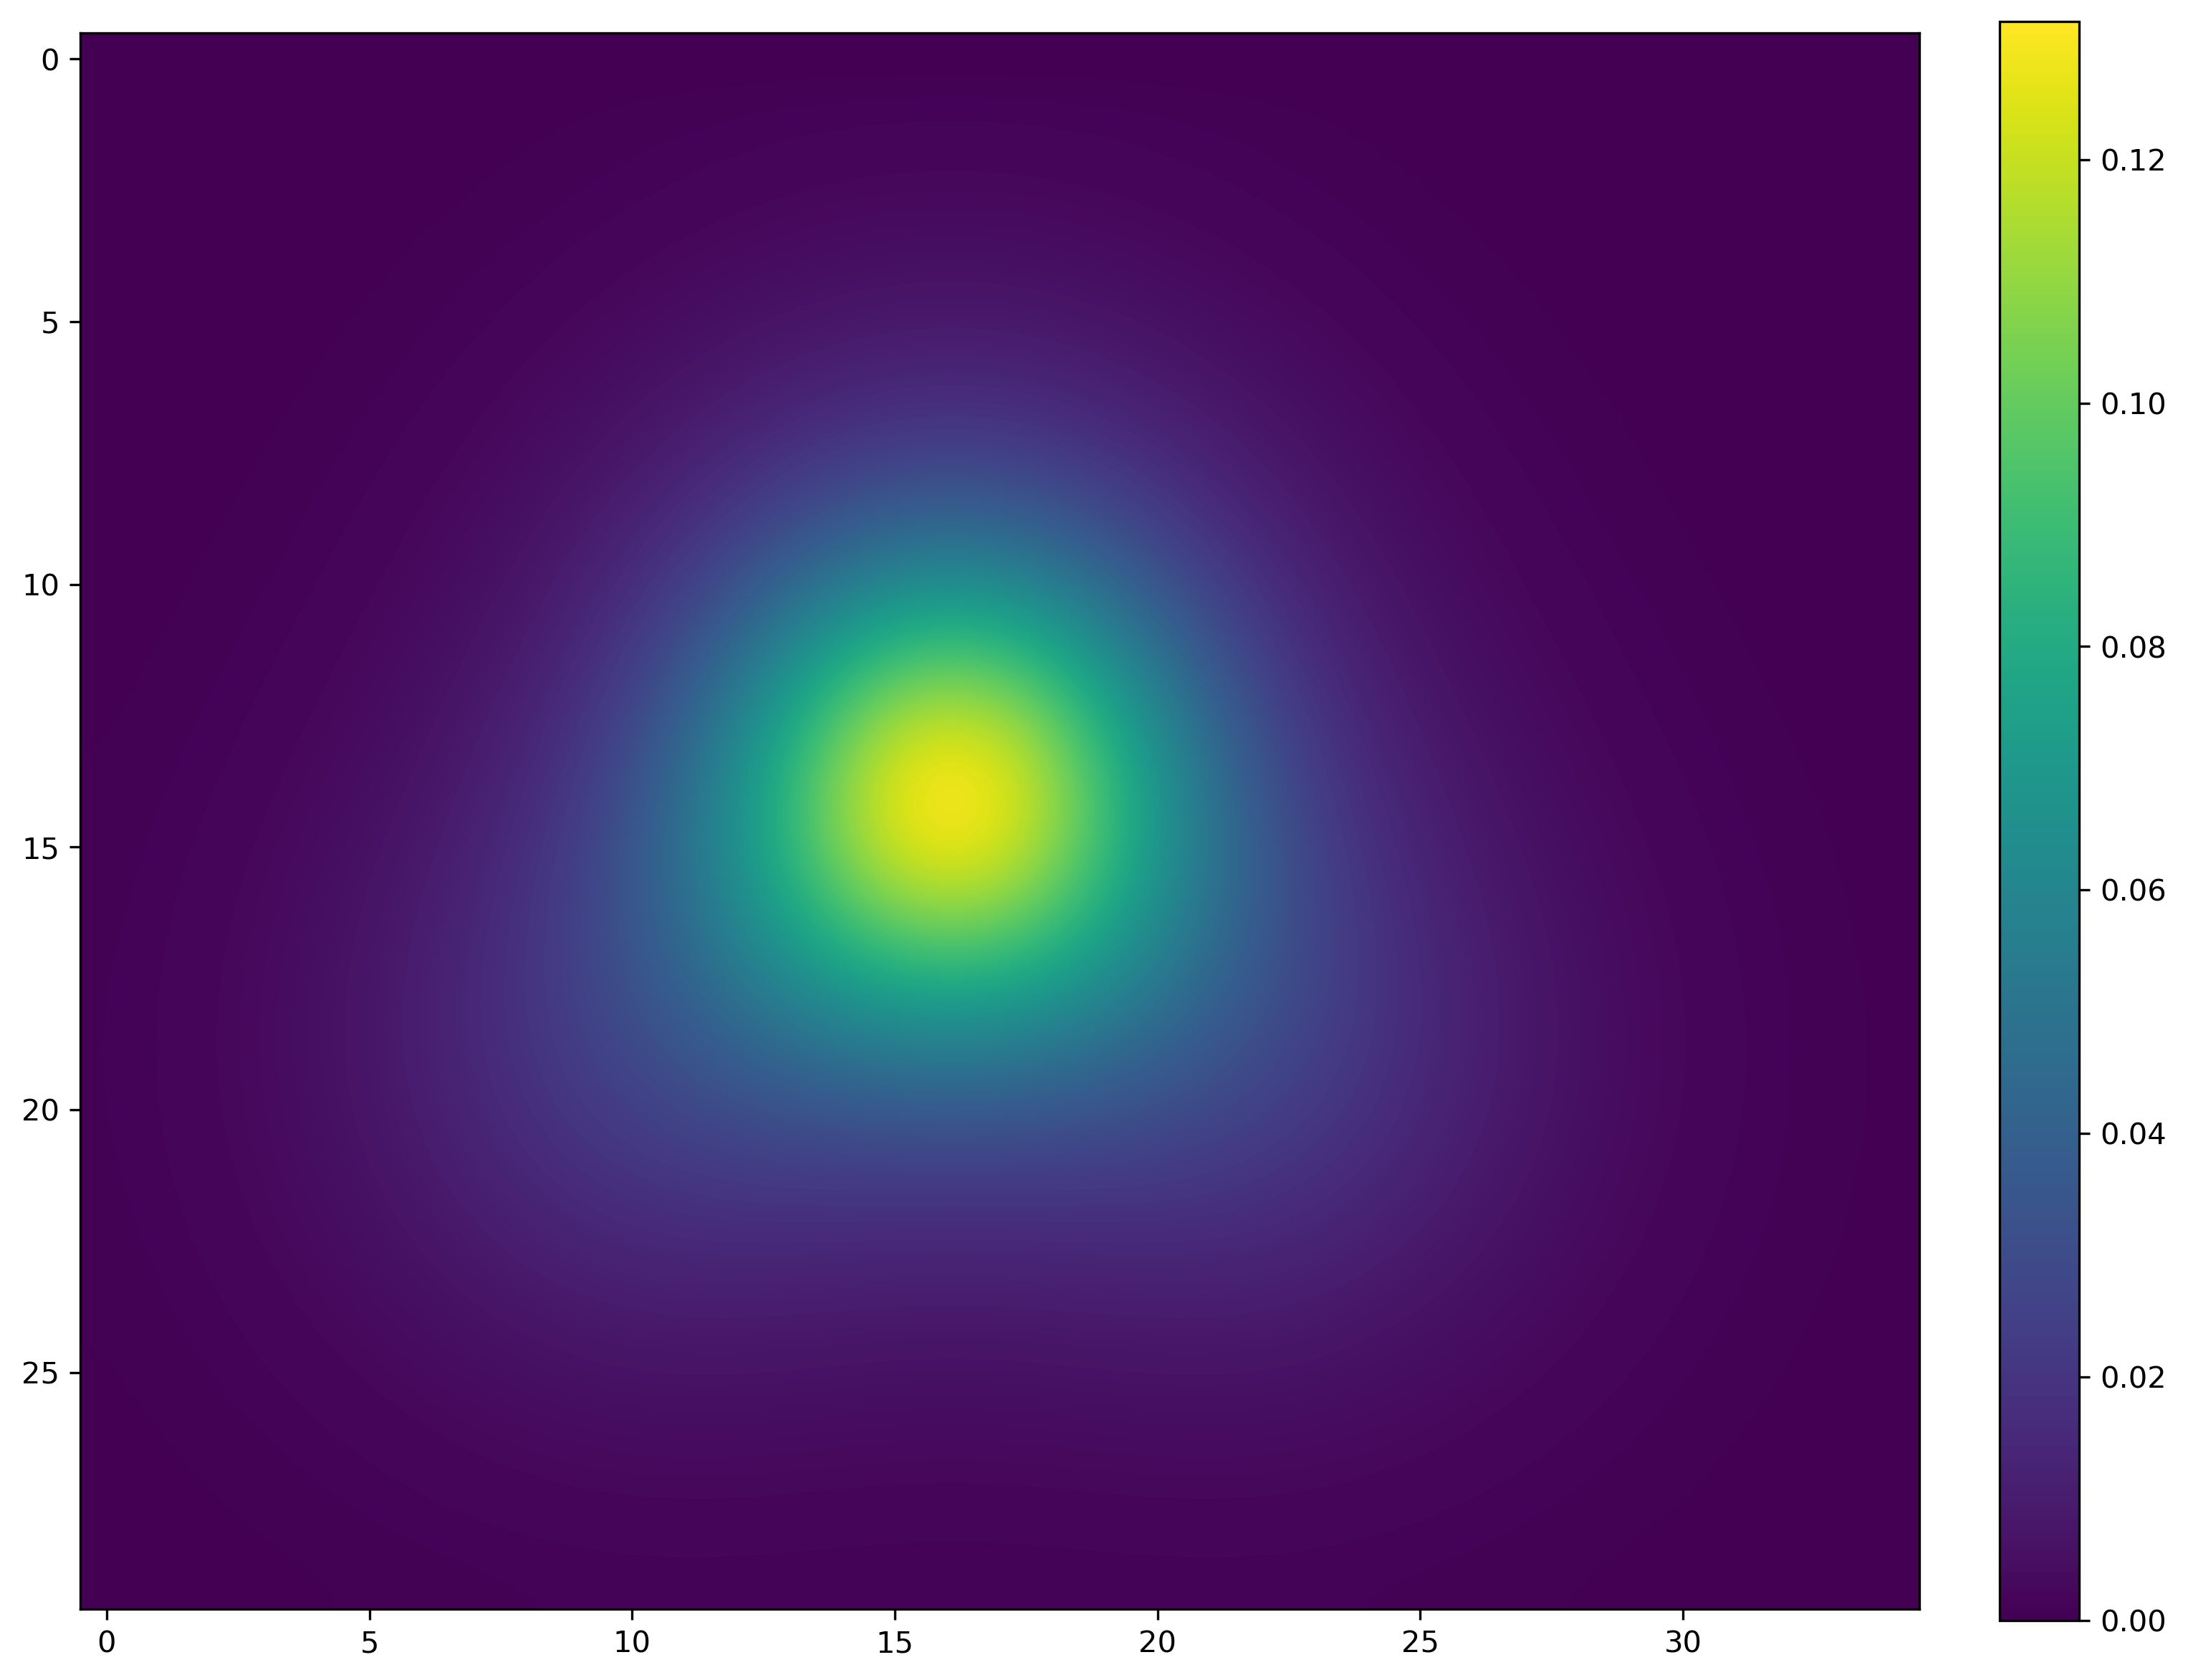

In [49]:
#We can bring the cubefile as a Numpy array
h2o_cube, cube_info = libcubeprop.cube_to_array("Water_Density.cube")

#And using Matplotlib we can compute the electron density of a slice
fig = plt.figure(figsize=(12,12), dpi=300)

#Rotate the image to match the previously shown models.
rotated_img = ndimage.rotate(h2o_cube[15:50,34,20:50], -90)

#Plot the grid interpolating using a bicubic method. 
plt.imshow(rotated_img, interpolation="bicubic")
plt.colorbar(fraction=0.040, pad=0.04)

We can produce a similar plot with the Psi4 calculation and the cubeprop function. 

In [45]:
#Psi4 can directly produce cube files by setting some global variables. 

psi4.set_options({"cubeprop_tasks": ['density'], 
                 "CUBIC_GRID_OVERAGE" : [8.0,  8.0, 8.0], 
                 "CUBIC_GRID_SPACING" : [0.2, 0.2, 0.2]})

#Make a psi4 calculation
h2o_energy, h2o_wfn = psi4.energy("PBE/cc-pVDZ", molecule=h2o_geometry,return_wfn=True)

#Use the wavefunction object to produce the density 
psi4.cubeprop(h2o_wfn)

#Use the same libcubeprop library to have the cube file as an array
h2o_cube_psi4, _ = libcubeprop.cube_to_array("Da.cube")

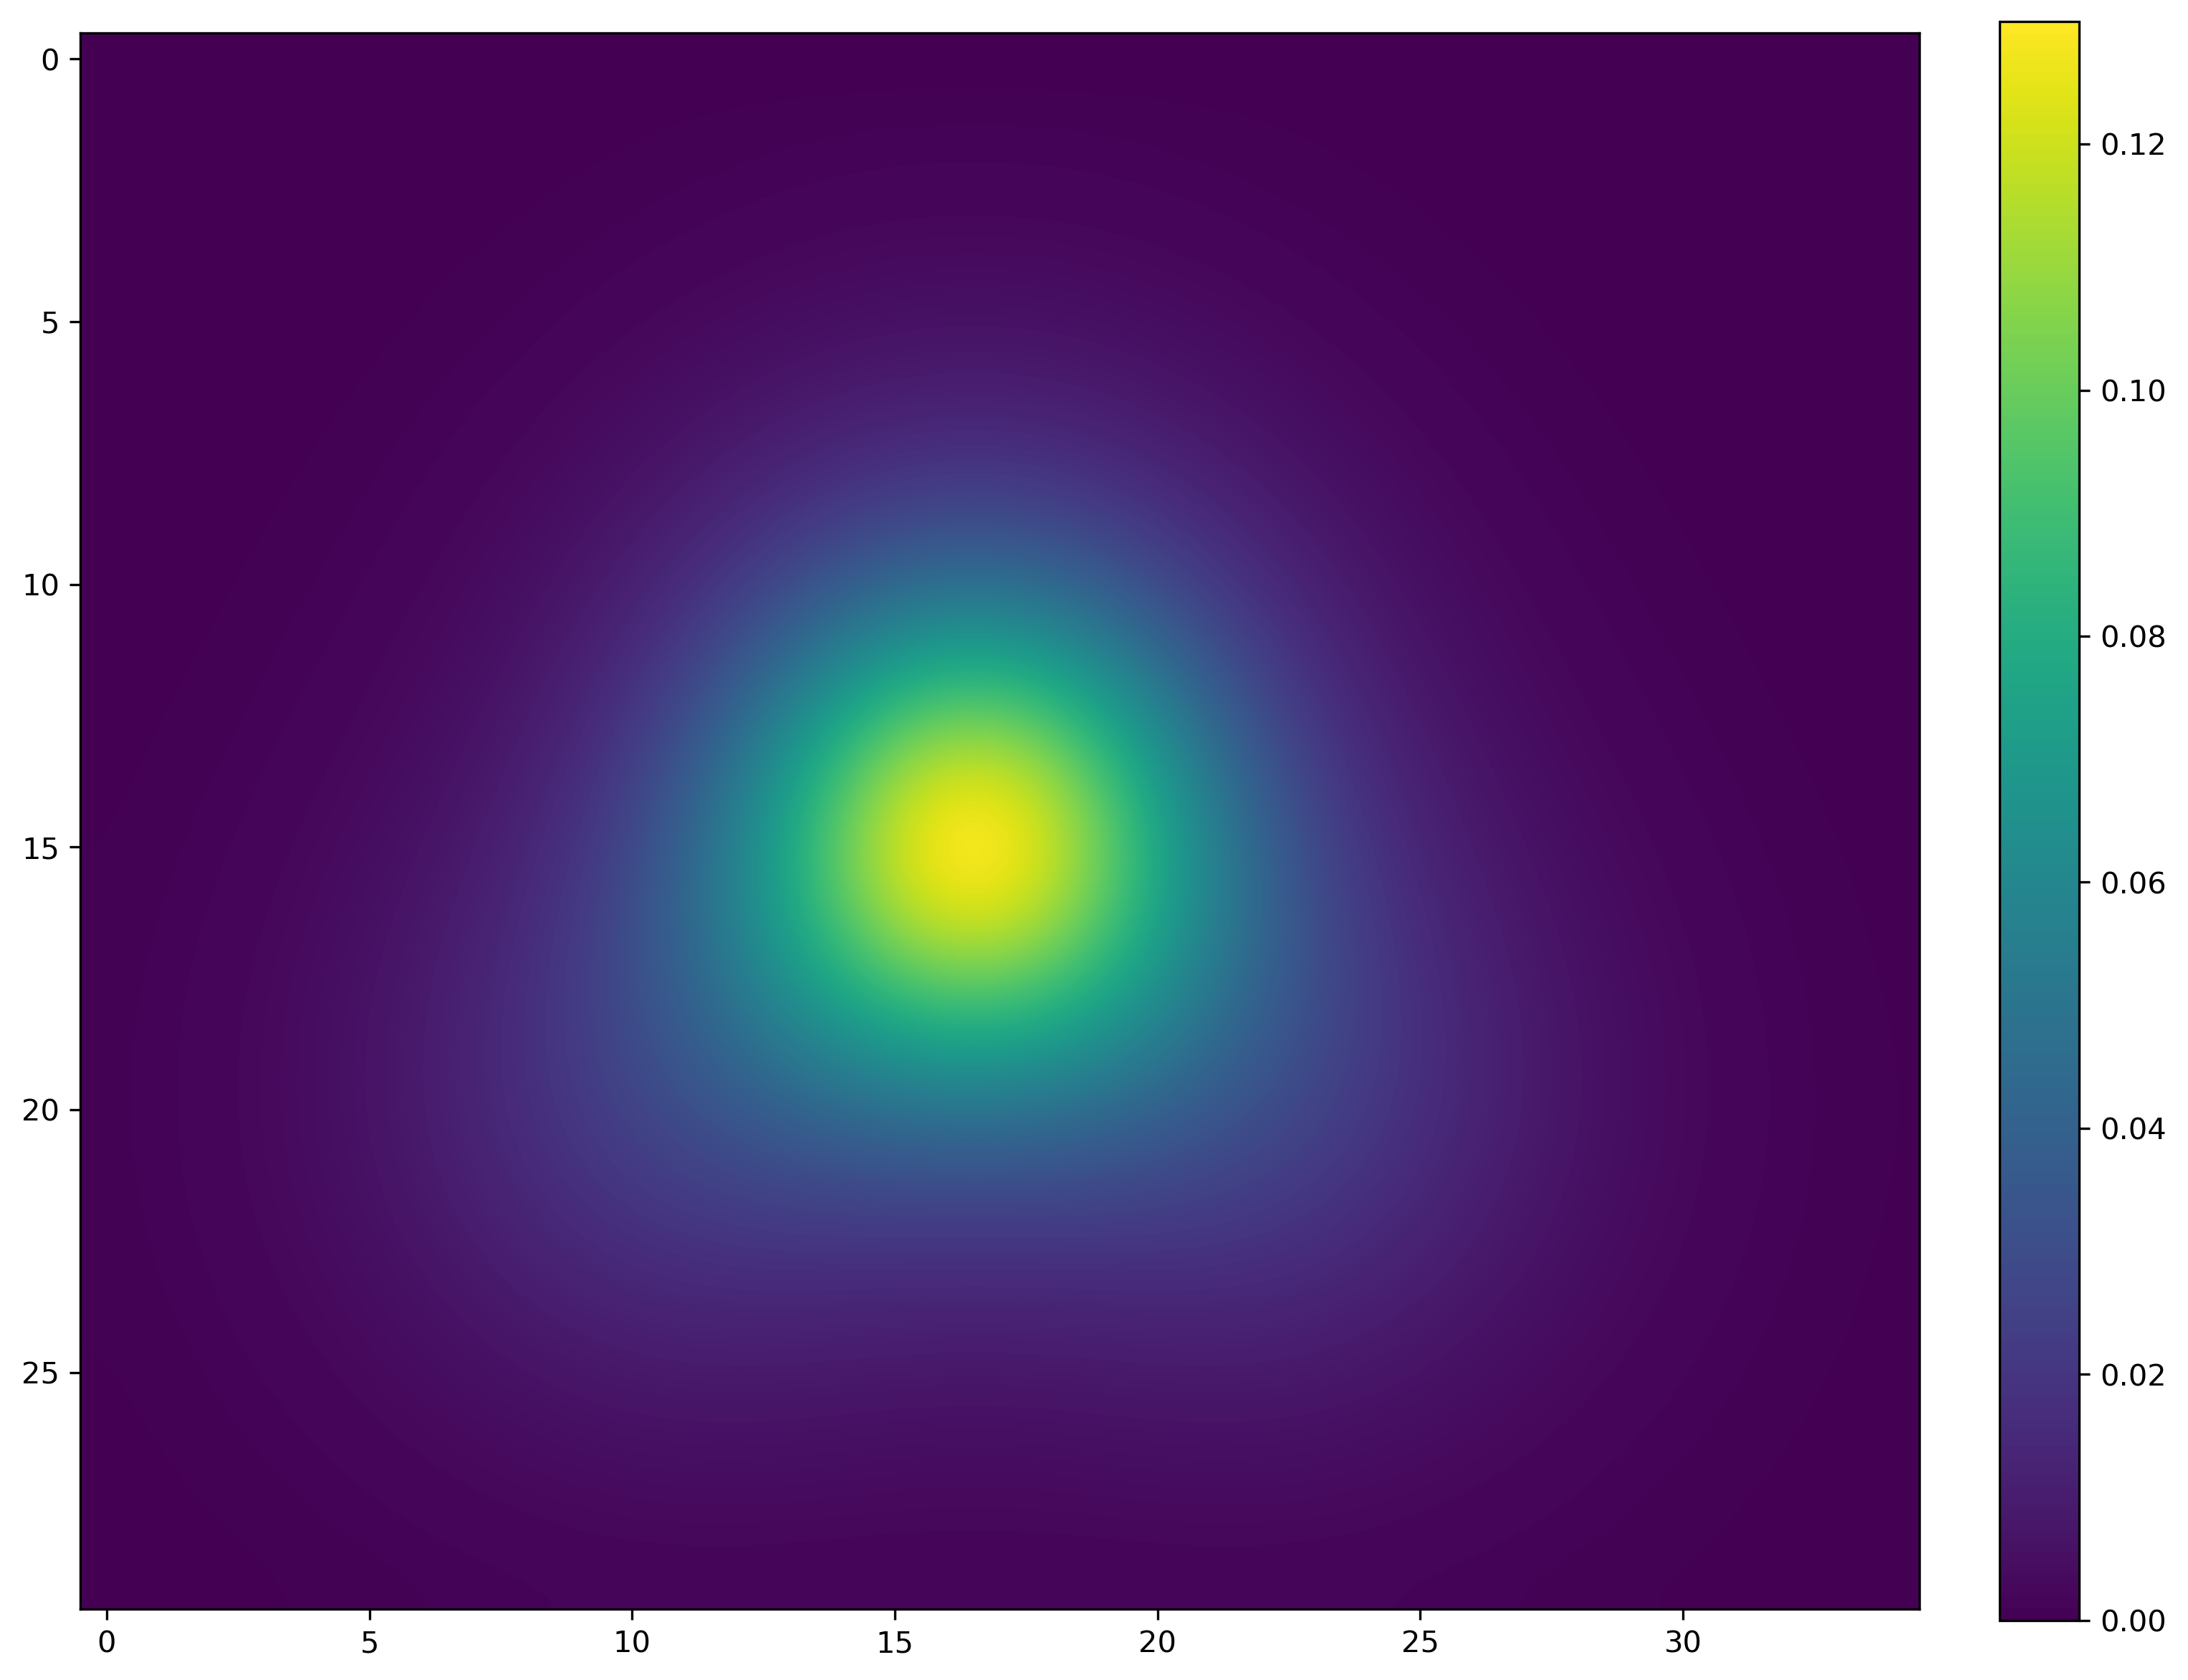

In [51]:
fig = plt.figure(figsize=(12,12), dpi=300)
rotated_cube = ndimage.rotate(h2o_cube_psi4[30:65,34,25:55], -90)
plt.imshow(rotated_cube, interpolation="bicubic")

plt.colorbar(fraction=0.040, pad=0.04)



Although here we only computed the density, psi4.cubeprop can be use to produce more elements like orbitals, basis functions, or electrostatic potential.
More details on cubeprop on http://www.psicode.org/psi4manual/1.2/cubeprop.html